In [623]:
#import libraries

#data manipulation
import numpy as np 
import pandas as pd
from datetime import timedelta, datetime

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#stats
from scipy import stats
from statsmodels.stats import weightstats as stests
import statsmodels.api as sm

#modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler


In [719]:
#import data
sb = pd.read_csv('Business case Sportsbook_data.csv', sep = ',')

In [720]:
#converting date to datetime format 
sb['date'] = sb['date'].apply(lambda x: pd.to_datetime(x))

### Exploratory Data Analysis

In [755]:
sb['bonus awarded'].value_counts()

5.0     3367
10.0    2793
20.0    2293
50.0    1392
Name: bonus awarded, dtype: int64

In [667]:
#checking number of unique playerids 
sb['playerid'].nunique()

689

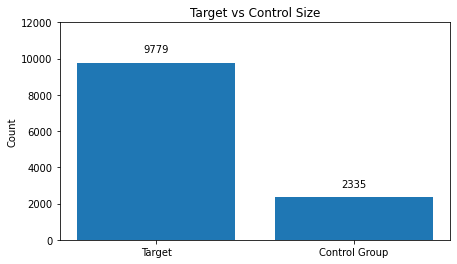

In [715]:
#looking at counts of playerids in each group
tgc = sb['Target/CG'].value_counts().to_frame()
plt.figure(figsize = (7,4))
_ = plt.bar(tgc.index, tgc['Target/CG'])
plt.title('Target vs Control Size')

for x,y in zip(tgc.index, tgc['Target/CG']):

    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.ylabel('Count')
plt.ylim(0,12000)
plt.show()

#### *Observation: Target by Subgroup*

We notice that Target rates are relatively constant around the ~0.80 mark for each customer subgroup, although VIP group is noticeably Targeted at 88% rate

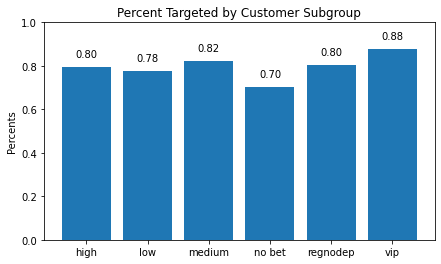

In [717]:
sb_tgt_ctrl = sb.groupby(['last_12months_segment','Target/CG']).count().unstack()['log_handle'].reset_index()  #.assign(new_col_target = lambda x: x['Target'] / (x['Target'] + x['Control']))  
sb_tgt_ctrl['perc_tgt'] = sb_tgt_ctrl['Target'] / (sb_tgt_ctrl['Target'] +
                                                   sb_tgt_ctrl['Control Group'])
sb_tgt_ctrl

#visualizing Target rates by customer subgroup

plt.figure(figsize = (7,4))
_ = plt.bar(sb_tgt_ctrl['last_12months_segment'], sb_tgt_ctrl['perc_tgt'])
plt.title('Percent Targeted by Customer Subgroup')
plt.ylabel('Percents')
for x,y in zip(sb_tgt_ctrl['last_12months_segment'], sb_tgt_ctrl['perc_tgt']):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.ylim(0,1)
plt.show()

In [478]:
#looking at whether any players changed levels during the marketing campaign to see if there are any discernible 
#differences in player segment mobility by Target vs Control
playerid_mobility_df = sb.groupby('playerid')[['last_12months_segment']].nunique().reset_index()
playerid_mobility_df.loc[playerid_mobility_df['last_12months_segment'] > 1]


,playerid,last_12months_segment


#### *Observation: Handle*

For purposes of this analysis we choose to focus on the handle variable given higher handle should, all else equal, result in higher profit for the business that is linearly proportional in the long run to the vig baked into the Sportsbook odds.

We observe high variability in the handle variable and therefore decide to take the log of the variable to reduce some of this variability and get higher linearity between our y's and x's for our regression analysis.


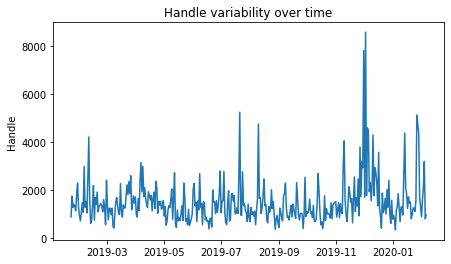

In [695]:
#variability in handle variable - time series view 
from datetime import timedelta

sb_grouped_date = sb.groupby('date')[['handle']].mean().reset_index()

plt.figure(figsize = (7,4))
_ = plt.plot(sb_grouped_date['date'], sb_grouped_date['handle'])
plt.title('Handle variability over time')
plt.ylabel('Handle')
plt.show()

In [721]:
#creating a log handle variable
sb['log_handle'] = np.where(sb['handle'] < 1, 1, sb['handle'])
sb['log_handle'] = np.log(sb['log_handle'])

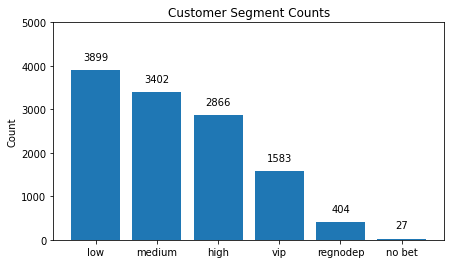

In [738]:
#visualizing counts of each segment not grouped by playerid
segment_counts = sb['last_12months_segment'].value_counts().to_frame()

plt.figure(figsize = (7,4))
_ = plt.bar(segment_counts.index, segment_counts['last_12months_segment'])
plt.title('Customer Segment Counts not Grouped by Playerid')

for x,y in zip(segment_counts.index, segment_counts['last_12months_segment']):

    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
plt.ylabel('Count')
plt.ylim(0,5000)
plt.show()

### Checking for Missing Values

We notice bonus awarded is the only variable with missing values in our data and that these occur only for the Control group which by definition has bonus awarded of zero. We therefore impute these missing values to zero

In [583]:
sb.isna().sum()

playerid                    0
date                        0
handle                      0
ggr                         0
last_12months_segment       0
Target/CG                   0
bonus awarded            2336
log_handle                  0
dtype: int64

In [585]:
#seeing all bonus awarded missing values occur in the Control Group
sb.set_index('Target/CG')[['bonus awarded']].isna().sum(level=0)

,bonus awarded
Target/CG,
Target,0
Control Group,2336


In [586]:
#imputing missing bonus awarded to zero
sb['bonus awarded'] = sb['bonus awarded'].fillna(0)

### Checking for Outliers

We identify ten outlier values in the log transformed handle variable that are removed to preempt any potential skew these outliers may introduce in our linear regression models.

In [734]:
#looking at groupby on playerid to check for any outliers

grouped_outliers = sb.groupby('playerid')[['log_handle']].mean()
q1, median, q3 = grouped_outliers.log_handle.quantile([0.25,0.5,0.75])
iqr = q3 - q1
min_outlier = q1 - 1.5 * iqr
max_outlier = q3 + 1.5 * iqr
outliers = grouped_outliers.loc[grouped_outliers['log_handle'] > max_outlier]
outlier_playerids = list(outliers.index)

In [726]:
outliers

,log_handle
playerid,
1135249,9.075532
1204930,9.557541
1230877,11.124883
1276799,11.081417
1285934,9.545383
1291803,8.731829
1292808,9.988388
1293083,9.132368
1300957,11.672021


Text(0.5, 1.0, 'Distribution of Mean Log_handle by Playerid')

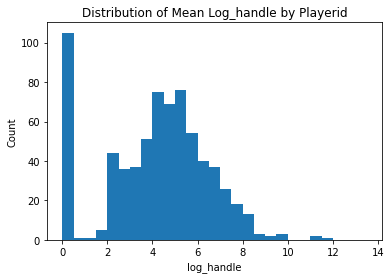

In [733]:
#visualizing outliers
plt.figure(figsize = (7,4))
plt.hist(grouped_outliers, bins = list(np.arange(0,14,0.5)))
plt.xlabel('log_handle')
plt.ylabel('Count')
plt.title('Distribution of Mean Log_handle by Playerid')

In [604]:
#given these outliers represent ~1% of our playerdata, we choose to remove
#these from the dataset in order to limit potential detrimental 
#impact on our regressions
sb = sb.loc[~sb['playerid'].isin(outlier_playerids)]

(12114, 8)

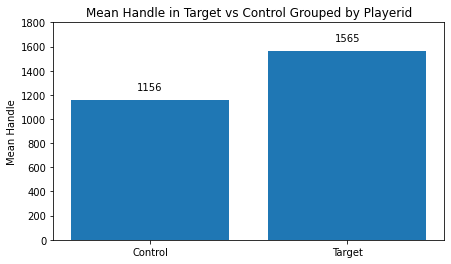

In [716]:
#looking at mean group differences after outlier treatment

sb.groupby('Target/CG')[['handle']].mean().reset_index()
plt.figure(figsize = (7,4))
_ = plt.bar(['Control','Target'],[1156,1565])
plt.title('Mean Handle in Target vs Control Grouped by Playerid')
plt.ylabel('Mean Handle')
for x,y in zip(['Control','Target'],[1156,1565]):

    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.ylim(0,1800)
plt.show()

### Preparing Data for Simple Linear Regression

#### *Observation - Bonus awarded:*

We notice a strong positive linear relationship between bonus awarded and handle from the below correlation heatmap. We would therefore expect bonus awarded to be a somewhat strong predictor in our linear regression
later on. Target vs Control have somewhat weak positive and negative correlation values with handle respectively, which may indicate these will be somewhat significant predictors later on

Text(0.5, 1.0, 'Numeric Variables Correlation Heatmap')

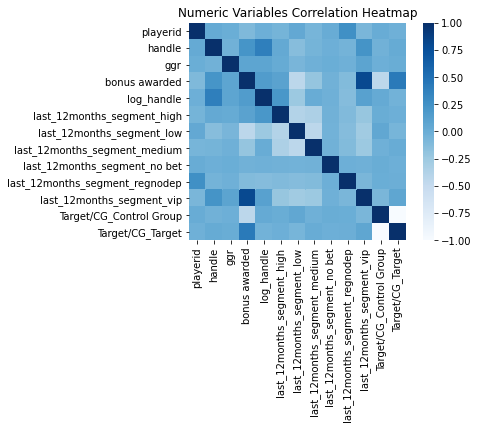

In [718]:
#looking at simple linear regression analysis grouping by playerid
#preparing data

#not setting drop_first = True to have greater control over which segments
#to drop
sb2 = pd.get_dummies(sb)

#creating correlation heatmap 
ax = plt.axes()
correlation = sb2.select_dtypes(['int64', 'float64','uint8']).corr()
sns.heatmap(correlation, square = True, cmap = 'Blues', ax = ax)
plt.title('Numeric Variables Correlation Heatmap')

In [617]:
#dropping one of each dummy variable for our linear models
sb2.drop(['last_12months_segment_no bet','Target/CG_Control Group'], axis = 1, inplace = True)

sb2_grouped = sb2.groupby('playerid')[['log_handle','bonus awarded','last_12months_segment_low',
                                     'last_12months_segment_medium','last_12months_segment_vip',
                                     'last_12months_segment_regnodep',
                                     'last_12months_segment_high','Target/CG_Target']].mean().reset_index()
sb2_grouped.drop(['playerid'], axis = 1, inplace = True)

In [ ]:
#creating our x's and y's
X = sb2_grouped.loc[:, sb2_grouped.columns != 'log_handle']
y = sb2_grouped['log_handle']

In [625]:
#high level not split by subgroup regression analysis
#we can see Target variable is statistically significant at 5% level 
#with 0.027 p-value
est2 = sm.OLS(y, X).fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             log_handle   R-squared (uncentered):                   0.785
Model:                            OLS   Adj. R-squared (uncentered):              0.782
Method:                 Least Squares   F-statistic:                              354.7
Date:                Sun, 14 Mar 2021   Prob (F-statistic):                   1.75e-222
Time:                        12:33:36   Log-Likelihood:                         -1512.2
No. Observations:                 689   AIC:                                      3038.
Df Residuals:                     682   BIC:                                      3070.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
bonus awarded                     -0.0348      0.033     -1.057      0.291      -0.100       0.030
last_12months_segment_low          4.3532      0.209     20.824      0.000       3.943       4.764
last_12months_segment_medium       4.7557      0.311     15.301      0.000       4.145       5.366
last_12months_segment_vip          6.9864      1.359      5.139      0.000       4.317       9.656
last_12months_segment_regnodep     2.7927      0.202     13.834      0.000       2.396       3.189
last_12months_segment_high         6.2609      0.564     11.103      0.000       5.154       7.368
Target/CG_Target                   0.6441      0.290      2.221      0.027       0.075       1.214
==============================================================================
Omnibus:                       46.481   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.550
Skew:                          -0.600   Prob(JB):                     3.19e-13
Kurtosis:                       3.751   Cond. No.                         147.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [634]:
#creating our function to return descriptive stats regressions by subgroup

def linear_regression_stats(segment = 'high'):    
    sb3 = sb.loc[sb['last_12months_segment'] == segment]
    sb3 = pd.get_dummies(sb3, drop_first = True)
    sb3 = sb3.groupby('playerid')[['log_handle','bonus awarded','Target/CG_Target']].mean().reset_index()
    sb3.drop(['playerid'], axis = 1, inplace = True)
    X_high = sb3.loc[:, sb3.columns != 'log_handle']
    y_high = sb3.loc[:, sb3.columns == 'log_handle']
    est_high = sm.OLS(y_high, X_high).fit()
    return est_high.summary()                           

In [792]:
#creating function to convert amount of bonus awarded to ROI
#based on our bonus awarded beta coefficients for each subgroup 

def convert_to_roi(coef, bonus):

    return (np.exp(coef) * bonus * 0.2 - bonus) / bonus 

In [635]:
linear_regression_stats('low')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             log_handle   R-squared (uncentered):                   0.626
Model:                            OLS   Adj. R-squared (uncentered):              0.625
Method:                 Least Squares   F-statistic:                              395.5
Date:                Sun, 14 Mar 2021   Prob (F-statistic):                    2.38e-52
Time:                        12:48:43   Log-Likelihood:                         -610.33
No. Observations:                 237   AIC:                                      1223.
Df Residuals:                     236   BIC:                                      1226.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
bonus awarded        0.9029      0.045     19.887      0.000       0.813       0.992
Target/CG_Target     0.1806      0.009     19.887      0.000       0.163       0.198
==============================================================================
Omnibus:                        0.526   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.769   Jarque-Bera (JB):                0.270
Skew:                          -0.006   Prob(JB):                        0.874
Kurtosis:                       3.165   Cond. No.                     6.83e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.01e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [757]:
print(np.exp(0.9029),np.exp(0.1806))
print('95% bonus awarded conf. int:',np.exp(0.813),np.exp(0.992))
print('95% Target/CG conf. int:',np.exp(0.163),np.exp(0.198))

2.4667463128155167 1.1979359090819148
95% bonus awarded conf. int: 2.254661836345618 2.696622327353013
95% Target/CG conf. int: 1.177036689688467 1.2189623938216427


In [793]:
convert_to_roi(0.9029, 5)

-0.5066507374368967

In [637]:
linear_regression_stats('medium')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             log_handle   R-squared (uncentered):                   0.655
Model:                            OLS   Adj. R-squared (uncentered):              0.650
Method:                 Least Squares   F-statistic:                              144.0
Date:                Sun, 14 Mar 2021   Prob (F-statistic):                    3.20e-19
Time:                        12:49:19   Log-Likelihood:                         -200.84
No. Observations:                  77   AIC:                                      403.7
Df Residuals:                      76   BIC:                                      406.0
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
bonus awarded        0.4912      0.041     12.002      0.000       0.410       0.573
Target/CG_Target     0.0491      0.004     12.002      0.000       0.041       0.057
==============================================================================
Omnibus:                        0.496   Durbin-Watson:                   1.773
Prob(Omnibus):                  0.781   Jarque-Bera (JB):                0.234
Skew:                          -0.130   Prob(JB):                        0.889
Kurtosis:                       3.071   Cond. No.                     3.90e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.24e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [749]:
print(np.exp(0.4912),np.exp(0.0491))
print('95% bonus awarded conf. int:',np.exp(0.410),np.exp(0.573))
print('95% Target/CG conf. int:',np.exp(0.041),np.exp(0.057))

1.6342761751572519 1.050325378026379
95% bonus awarded conf. int: 1.5068177851128535 1.773579817752941
95% Target/CG conf. int: 1.0418521055454795 1.0586558103955002


In [794]:
convert_to_roi(0.4912, 10)

-0.6731447649685496

In [638]:
linear_regression_stats('high')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             log_handle   R-squared (uncentered):                   0.692
Model:                            OLS   Adj. R-squared (uncentered):              0.680
Method:                 Least Squares   F-statistic:                              58.47
Date:                Sun, 14 Mar 2021   Prob (F-statistic):                    4.08e-08
Time:                        12:49:19   Log-Likelihood:                         -72.993
No. Observations:                  27   AIC:                                      148.0
Df Residuals:                      26   BIC:                                      149.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
bonus awarded        0.3064      0.040      7.647      0.000       0.224       0.389
Target/CG_Target     0.0153      0.002      7.647      0.000       0.011       0.019
==============================================================================
Omnibus:                        1.232   Durbin-Watson:                   1.434
Prob(Omnibus):                  0.540   Jarque-Bera (JB):                0.291
Skew:                          -0.069   Prob(JB):                        0.864
Kurtosis:                       3.490   Cond. No.                     6.55e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.96e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [748]:
print(np.exp(0.3064),np.exp(0.0153))
print('95% bonus awarded conf. int:',np.exp(0.224),np.exp(0.389))
print('95% Target/CG conf. int:',np.exp(0.011),np.exp(0.019))

1.3585256081235828 1.01541764421976
95% bonus awarded conf. int: 1.2510710194283623 1.475504551333055
95% Target/CG conf. int: 1.0110607224447195 1.0191816486174081


In [795]:
convert_to_roi(0.3064, 10)

-0.7282948783752834

In [636]:
linear_regression_stats('vip')

/Users/philippeheitzmann/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             log_handle   R-squared (uncentered):                   0.673
Model:                            OLS   Adj. R-squared (uncentered):              0.643
Method:                 Least Squares   F-statistic:                              22.64
Date:                Sun, 14 Mar 2021   Prob (F-statistic):                    0.000591
Time:                        12:49:17   Log-Likelihood:                         -33.099
No. Observations:                  12   AIC:                                      68.20
Df Residuals:                      11   BIC:                                      68.68
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
bonus awarded        0.1199      0.025      4.759      0.001       0.064       0.175
Target/CG_Target     0.0024      0.001      4.759      0.001       0.001       0.004
==============================================================================
Omnibus:                        2.336   Durbin-Watson:                   2.286
Prob(Omnibus):                  0.311   Jarque-Bera (JB):                0.835
Skew:                          -0.640   Prob(JB):                        0.659
Kurtosis:                       3.181   Cond. No.                     2.37e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.44e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [751]:
print(np.exp(0.1199),np.exp(0.0024))
print('95% bonus awarded conf. int:',np.exp(0.064),np.exp(0.175))
print('95% Target/CG conf. int:',np.exp(0.001),np.exp(0.004))

1.127384107531514 1.002402882305383
95% bonus awarded conf. int: 1.0660923987615052 1.191246216612358
95% Target/CG conf. int: 1.0010005001667084 1.004008010677342


In [796]:
convert_to_roi(0.1199, 50)

-0.7745231784936972

In [639]:
linear_regression_stats('regnodep')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             log_handle   R-squared (uncentered):                   0.595
Model:                            OLS   Adj. R-squared (uncentered):              0.594
Method:                 Least Squares   F-statistic:                              457.2
Date:                Sun, 14 Mar 2021   Prob (F-statistic):                    4.97e-63
Time:                        12:49:48   Log-Likelihood:                         -703.57
No. Observations:                 312   AIC:                                      1409.
Df Residuals:                     311   BIC:                                      1413.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
bonus awarded        0.6022      0.028     21.383      0.000       0.547       0.658
Target/CG_Target     0.1204      0.006     21.383      0.000       0.109       0.132
==============================================================================
Omnibus:                        0.787   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.675   Jarque-Bera (JB):                0.901
Skew:                           0.083   Prob(JB):                        0.637
Kurtosis:                       2.796   Cond. No.                     8.79e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.38e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [660]:
sb.groupby('last_12months_segment')[['bonus awarded']].mean()

,bonus awarded
last_12months_segment,
high,15.924609
low,3.877917
medium,8.208603
no bet,3.518519
regnodep,4.009901
vip,43.948035


In [747]:
print(np.exp(0.6022),np.exp(0.1204))
print('95% bonus awarded conf. int:',np.exp(0.547),np.exp(0.658))
print('95% Target/CG conf. int:',np.exp(0.109),np.exp(0.132))

1.8261318745142978 1.1279479405317834
95% bonus awarded conf. int: 1.7280610506585812 1.9309266167394625
95% Target/CG conf. int: 1.1151623503414478 1.141108319267235


In [797]:
convert_to_roi(0.6022, 5)

-0.6347736250971404

In [640]:
linear_regression_stats('no bet')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             log_handle   R-squared (uncentered):                   0.557
Model:                            OLS   Adj. R-squared (uncentered):              0.538
Method:                 Least Squares   F-statistic:                              28.94
Date:                Sun, 14 Mar 2021   Prob (F-statistic):                    1.83e-05
Time:                        12:50:00   Log-Likelihood:                         -60.603
No. Observations:                  24   AIC:                                      123.2
Df Residuals:                      23   BIC:                                      124.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
bonus awarded        0.7529      0.140      5.379      0.000       0.463       1.042
Target/CG_Target     0.1506      0.028      5.379      0.000       0.093       0.208
==============================================================================
Omnibus:                        0.055   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.973   Jarque-Bera (JB):                0.183
Skew:                          -0.097   Prob(JB):                        0.913
Kurtosis:                       2.619   Cond. No.                     5.76e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.41e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [746]:
print(np.exp(0.7529),np.exp(0.1506))
print('95% bonus awarded conf. int:',np.exp(0.463),np.exp(1.042))
print('95% Target/CG conf. int:',np.exp(0.093),np.exp(0.208))

2.123148227257416 1.162531552445916
95% bonus awarded conf. int: 1.58883334241608 2.8348811105884675
95% Target/CG conf. int: 1.097461735268082 1.2312131695488677


In [798]:
convert_to_roi(0.7529, 5)

-0.5753703545485167